<a href="https://colab.research.google.com/github/jinyoungkim0214/portfolio/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [ ]:
# SIFT is excluded in recent OpenCV versions
# Solution: use opencv-python==3.4.2.17
!pip install opencv-python
!pip install opencv-contrib-python #머신러닝 실습임 (다른 파일이랑 비교해서 보기 - 성능이 안 좋음)

In [ ]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("OpenCV-Python Version %s" % cv2.__version__)

OpenCV-Python Version 4.11.0


In [ ]:
# download dataset
!pip install -U --no-cache-dir gdown --pre
!gdown --fuzzy 'https://drive.google.com/file/d/1fAjSR-Vkl6LvlK0G2OZPrsVAoQwijRpx/view?usp=sharing'

Downloading...
From (original): https://drive.google.com/uc?id=1fAjSR-Vkl6LvlK0G2OZPrsVAoQwijRpx
From (redirected): https://drive.google.com/uc?id=1fAjSR-Vkl6LvlK0G2OZPrsVAoQwijRpx&confirm=t&uuid=278452f9-1fab-46fa-90ef-ba03391b73c0
To: /content/101_ObjectCategories.tar.gz
100% 132M/132M [00:02<00:00, 53.0MB/s]


In [ ]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [ ]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Extracting Caltech-101
Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


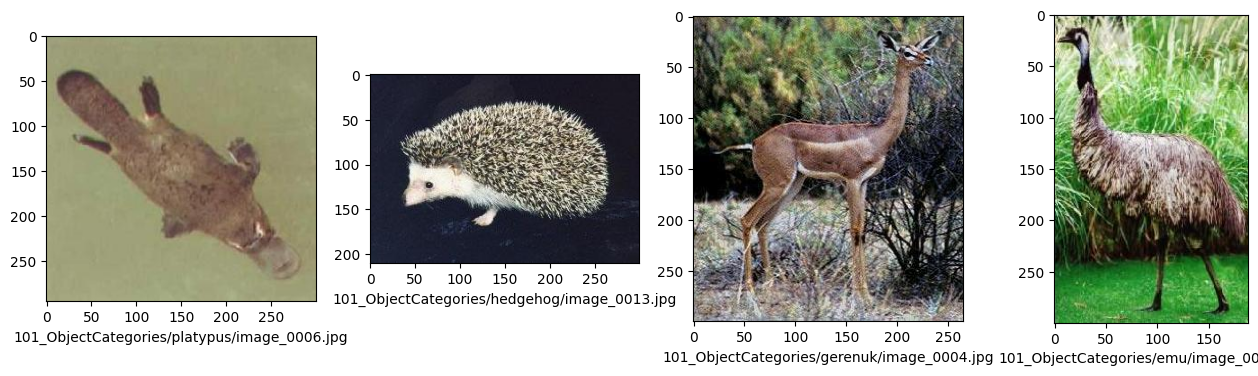

In [ ]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)
plt.show()

## 1. SIFT helper functions

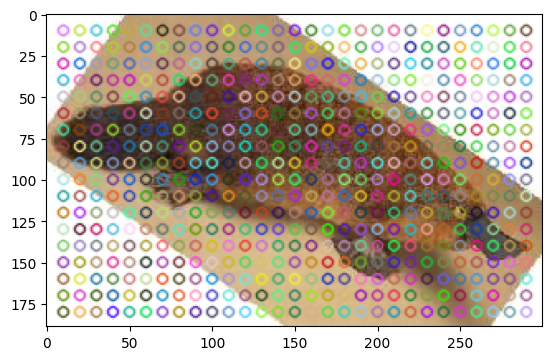

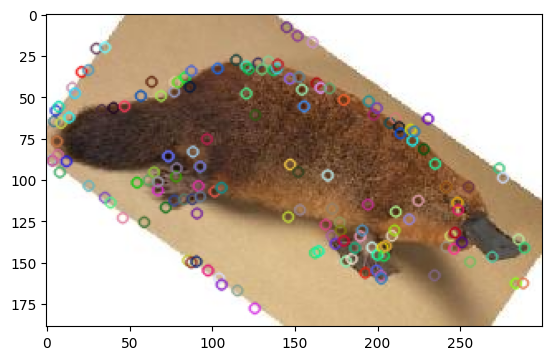

In [ ]:
sift = cv2.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img): #descriptor_keypoint개수*128
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath): #그경로에서흑백으로이미지 불러와서 resize시킨뒤(standar~) sift 알고리즘 적용 #2개위에거 합쳐서 sift2 만듦
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image) grid 위치에서 이미지의 특징 추출
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2] #row,column 받아와서 for문 돌면서 키포인트 생성
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10): #그경로에서흑백으로이미지 불러와서 resize시킨뒤(standar~) dense sift 알고리즘 적용 #2개위에거 합쳐서 sift2 만듦
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT 이미지 plot해라!
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp1, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp1, None)
plt.imshow(im_sift) # image is already converted to RGB, do not convert again
plt.show()

# SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp2, des = SIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp2, None)
plt.imshow(im_sift) # image is already converted to RGB, do not convert again
plt.show()

In [ ]:
print(len(kp1))
print(len(kp2))

522
164


## 2. Visual Words(Train Vocabulary)

In [ ]:
# Download pre-extracted vocab.pkl
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl

--2025-04-13 05:19:29--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307361 (300K) [application/octet-stream]
Saving to: ‘vocab.pkl’

vocab.pkl           100%[===================>] 300.16K  --.-KB/s    in 0.03s   

2025-04-13 05:19:29 (9.75 MB/s) - ‘vocab.pkl’ saved [307361/307361]



In [ ]:
# Train vocabulary #머신러닝으로 이미지 분류 (알고리즘을 쓴다 - 딥러닝은 그냥 신경망 열심히 엮어주는 느낌) test accuracy 많이 차이남 (파이토치 하이레벨 파일은 딥러닝)
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features from some training images...")
    PHOW_descrs = [] #feature을 뽑아내려고 -> 나중에 for문에서 append (바구니 느낌)
    temp = [item for sublist in train_image_ll for item in sublist]
    '''
    # above line is same function as below lines
    temp = []
    for sublist in train_image_ll:
        for item in sublist:
            temp.append(item)
    '''
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))

    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 1
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))

    print('Saving...')
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
    import collections
    myCounter = collections.Counter(bestLabels.flatten())
    plt.plot(sorted(myCounter.values()))
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

Load the trained visual words...
Done!


# Classification - SVM

## Spatial Histogram

In [ ]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]

    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1) #각각의 매치쌍을 만들어줌, 가까운 건 가까운 데로 clustering
    words = [m[0].trainIdx for m in matches]

    # Spatial Binning - 2x2
    binX = 2
    binY = 2
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp

    # Spatial Binning - 4x4
    ################################
    # TODO : your code here
    #temp = None
    temp = []

    # Spatial Binning - 4x4
    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    # temp: bag of the word.

    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1

    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()


    # here we concat 4x4 binned descriptors to 2x2 binned descriptors
    hist = np.concatenate((hist, temp), axis=0)
    ################################

    hist /= np.sum(hist)
    return hist

## 1. Genarate spatial histogram for Training Images

In [ ]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c)
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
platypus
mayfly
dalmatian
stapler
cellphone
rooster
Leopards
cougar_body
kangaroo
grand_piano
joshua_tree
ketch
flamingo_head
elephant
saxophone
BACKGROUND_Google
sunflower
panda
buddha
bonsai
metronome
Faces
dollar_bill
helicopter
soccer_ball
chair
schooner
barrel
brain
garfield
emu
trilobite
camera
chandelier
gramophone
crocodile_head
lamp
lotus
nautilus
starfish
ibis
crab
electric_guitar
water_lilly
airplanes
okapi
stegosaurus
wrench
dolphin
Faces_easy
inline_skate
stop_sign
bass
watch
ceiling_fan
crayfish
binocular
pyramid
accordion
crocodile
strawberry
scissors
gerenuk
mandolin
llama
umbrella
Motorbikes
tick
cup
octopus
wild_cat
ewer
windsor_chair
ferry
brontosaurus
headphone
snoopy
cannon
anchor
sea_horse
hawksbill
dragonfly
laptop
pagoda
hedgehog
menorah
lobster
yin_yang
wheelchair
beaver
euphonium
revolver
minaret
scorpion
cougar_face
flamingo
pizza
ant
car_side
butterfly
rhino
pigeon

done!


## 2. Train SVM

In [ ]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int32).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)
print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow:  (1530, 12000)
train_labels:  (1530, 1)


In [ ]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 21.793544054031372s
Done!


In [ ]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.990196


## 3. Test trained SVM

In [ ]:
# Extract spartial histogram for all test images
print('Extract spartial histogram for all test images\n')
################################
# TODO : your code here
BoW_test_ll = []

for c, image_list in zip(classes, test_image_ll):
    print(c, end=' '),
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)

print('\ndone!')
################################

Extract spartial histogram for all test images

platypus mayfly dalmatian stapler cellphone rooster Leopards cougar_body kangaroo grand_piano joshua_tree ketch flamingo_head elephant saxophone BACKGROUND_Google sunflower panda buddha bonsai metronome Faces dollar_bill helicopter soccer_ball chair schooner barrel brain garfield emu trilobite camera chandelier gramophone crocodile_head lamp lotus nautilus starfish ibis crab electric_guitar water_lilly airplanes okapi stegosaurus wrench dolphin Faces_easy inline_skate stop_sign bass watch ceiling_fan crayfish binocular pyramid accordion crocodile strawberry scissors gerenuk mandolin llama umbrella Motorbikes tick cup octopus wild_cat ewer windsor_chair ferry brontosaurus headphone snoopy cannon anchor sea_horse hawksbill dragonfly laptop pagoda hedgehog menorah lobster yin_yang wheelchair beaver euphonium revolver minaret scorpion cougar_face flamingo pizza ant car_side butterfly rhino pigeon 
done!


In [ ]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])
################################
# TODO : your inference code here
# Make sure to apply Hellinger's kernel!

for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))

test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int32).reshape((numTest*numClasses,1))

# test_bow = None
# test_labels = None

print(test_bow.shape)
print(test_labels.shape)
################################

Setting test data(BoW, label) for SVM
(1530, 12000)
(1530, 1)


In [ ]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

Test Accuracy: 0.4084967320261438


## 4. Sample Results

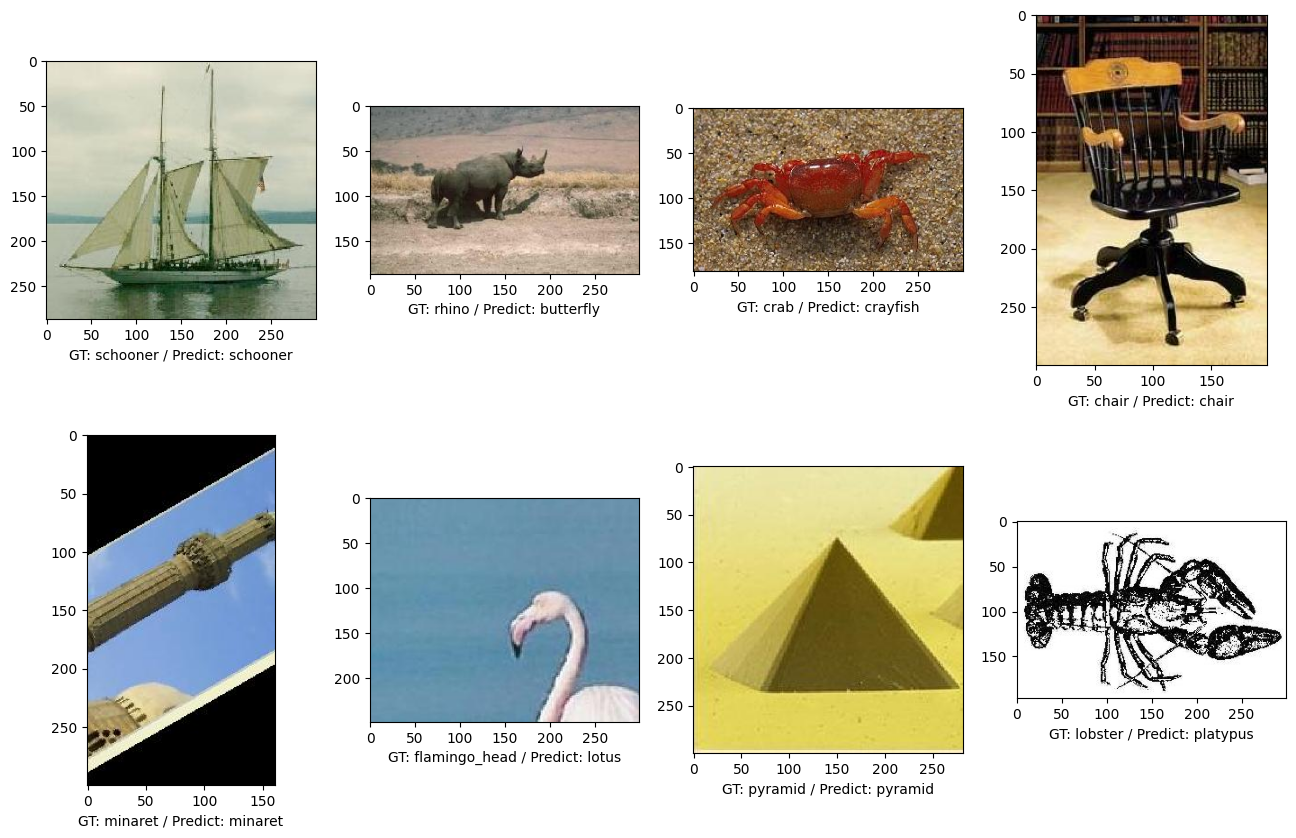

In [ ]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])

    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Practice: Classify your own image

Choose and classify your own test image using our classification.

0. Place your image in the path where this notebook can access
1. Load an image as grayscale
2. Extract Dense SIFT BoW with `getImageDescriptor()`
3. Normalize the bow with Hellinger's kernel
4. Predict using the SVM classifier we have trained so far(`svm` instance)

In [ ]:
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg

--2025-04-13 05:27:41--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23885 (23K) [image/jpeg]
Saving to: ‘dragonfly.jpg’

dragonfly.jpg       100%[===================>]  23.33K  --.-KB/s    in 0.001s  

2025-04-13 05:27:41 (19.6 MB/s) - ‘dragonfly.jpg’ saved [23885/23885]



In [ ]:
# TODO 1: Load an image as grayscale
img_fpath = None  # Path to your own image
img = None

#================ YOUR CODE HERE ===================
# TODO 2: BoW of the image
# TODO 3: Hellinger's kernel
# TODO 4: Prediction
prediction = None
#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))
plt.show()

In [ ]:
# Desired output: dragonfly
# It could be predicted wrong :)